In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Take the bounding box of the images

In [2]:
annotations_dir = 'annotations'
images_dir = 'images'

img_lst = []
label_lst = []
count = 0
for xml_file in os.listdir(annotations_dir):  #Get the file's name of the files in the folder 'annoutations'
    xml_filepath = os.path.join(annotations_dir,xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()
    
    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(folder, img_filename)
    img = cv2.imread(img_filepath)
    
    for obj in tree.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue
        
        x_min = int(obj.find('bndbox/xmin').text)
        y_min = int(obj.find('bndbox/ymin').text)
        x_max = int(obj.find('bndbox/xmax').text)
        y_max = int(obj.find('bndbox/ymax').text)

        object_img = img[y_min:y_max, x_min:x_max]
        img_lst.append(object_img)
        label_lst.append(classname)

print(f"Number of Object: {len(img_lst)}")
print(f"Class Name: {list(set(label_lst))}")
print(f"Image shape: {img_lst[0].shape}")
flattened_img = img_lst[0].flatten()
print(f"Image shape after flatten: {flattened_img.shape}")

Number of Object: 1074
Class Name: ['stop', 'speedlimit', 'crosswalk']
Image shape: (321, 328, 3)
Image shape after flatten: (315864,)


Pre-processing images

In [3]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)
    
    resized_img = resize(
        img,
        output_shape = (32,32),
        anti_aliasing=True
    )
    
    hog_feature = feature.hog(
        resized_img,
        orientations=9,     #Devide 180 degree into 9 bins with the range of 20 degree
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True #Flatten and generate the feature vector
    )
    
    return hog_feature

img_feature_lst = []
for img in img_lst:
    hog_feature = preprocess_img(img)
    img_feature_lst.append(hog_feature)

img_features = np.array(img_feature_lst)

print(f"Shape of the first image: {img_lst[0].shape}")
print(f"X shape after using HoG: {img_features.shape}")


Shape of the first image: (321, 328, 3)
X shape after using HoG: (1074, 324)


Normalization

In [4]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(label_lst)
print(f"Classname: {label_encoder.inverse_transform(encoded_label)[list(encoded_label).index(0)]} - Encoded: 0")
print(f"Classname: {label_encoder.inverse_transform(encoded_label)[list(encoded_label).index(1)]} - Encoded: 1")
print(f"Classname: {label_encoder.inverse_transform(encoded_label)[list(encoded_label).index(2)]} - Encoded: 2")

Classname: crosswalk - Encoded: 0
Classname: speedlimit - Encoded: 1
Classname: stop - Encoded: 2


Devide dataset into train and test set, normalization train and test set

In [5]:
random_state = 0
test_size = 0.3
is_shuffle = False

X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_label,
    random_state=random_state,
    test_size=test_size,
    shuffle=is_shuffle
)

#Normalization data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Training dataset using SVM

In [6]:
clf = SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True,
    degree=2,
    C=0.5
)
clf.fit(X_train, y_train)

SVC(C=0.5, degree=2, probability=True, random_state=0)

Evaluation the accuracy of SVM model

In [7]:
y_pred = clf.predict(X_val)
print(f"Accuracy: {accuracy_score(y_pred, y_val)}")
print(confusion_matrix(y_pred, y_val))
print(classification_report(y_pred, y_val))

Accuracy: 0.9659442724458205
[[ 29   1   3]
 [  0 250   7]
 [  0   0  33]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        33
           1       1.00      0.97      0.98       257
           2       0.77      1.00      0.87        33

    accuracy                           0.97       323
   macro avg       0.92      0.95      0.93       323
weighted avg       0.97      0.97      0.97       323



Test an image

In [8]:
input_img = img_lst[863]
visualize_img = cv2.imread('images/bienbao.jpg')
#visualize_img = visualize_img[yymin:yymax, xxmin:xxmax]
normalized_img = preprocess_img(input_img)
y_pred = clf.predict([normalized_img])[0]
print(f"Normal prediction: {y_pred}")
y_pred_prob = clf.predict_proba([normalized_img])
prediction = np.argmax(y_pred_prob)
y_pred_prob = [f'{p:.10f}' for p in y_pred_prob[0]]
print(f"Probablity of each class: {y_pred_prob}")
print(f"Class with highest probability: {prediction}")


Normal prediction: 1
Probablity of each class: ['0.0000000166', '0.9998612219', '0.0001387615']
Class with highest probability: 1


Sliding Window and Paramid image

In [9]:
#Sliding Window
def sliding_window(img, window_sizes, stride):
    img_height, img_width = img.shape[:2]
    windows = []
    for window in window_sizes:
        window_width, window_height = window
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height
                
                windows.append([xmin, ymin, xmax, ymax])
    return windows

#Pyramid Images
def pyramid(img, scale, min_size):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]
    
    i = 0
    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img, (w,h))
        pyramid_imgs.append((img, acc_scale))  ###
        i += 1
    
    return pyramid_imgs

Visualize Bounding Box

In [10]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    
    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box
        first_point = xmin, ymin
        last_point = xmax, ymax
        cv2.rectangle(img, first_point, last_point, (0, 255, 0), 2)
        
        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score: .2f}"
        
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (xmin, ymin-20), (xmin + w, ymin), (0, 255, 0), -1)
        
        cv2.putText(img, label, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Drawing all the sliding window in this image

In [11]:
scale = 0.8
min_size =(16, 16)
bboxes = []
def draw_all_bbox(pyramid_imgs):
    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes=[(16, 16), (32, 32), (64, 64), (128, 128)],
            stride=4
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            conf_threshold = 0.95
            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score])
    return bboxes

Compute iou and nms

In [12]:
def iou_bbox(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    
    #Compute the intersection area
    x1 = max(b1_x1, b2_x1)
    y1 = max(b1_y1, b2_y1)
    x2 = min(b1_x2, b2_x2)
    y2 = min(b1_y2, b2_y2)
    
    inter = max((x2-x1), 0) * max((y2 - y1), 0)
    
    #Compute union area
    boxArea1 = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
    boxArea2 = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))
    union = float(boxArea1 + boxArea2 - inter)
    
    iou = inter / union
    return iou

# def compute_iou(bbox_max, bbox_lst):
#     iou = []
#     for bbox in bbox_lst:
#         iou_bboxs = iou_bbox(bbox_max, bbox)
#         iou.append(iou_bboxs)
#     return np.array(iou)

def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    x_min = np.maximum(bbox[0], bboxes[:, 0])
    y_min = np.maximum(bbox[1], bboxes[:, 1])
    
    x_max = np.minimum(bbox[2], bboxes[:, 2])
    y_max = np.minimum(bbox[3], bboxes[:, 3])
    
    w = np.maximum(0, x_max - x_min + 1)
    h = np.maximum(0, y_max - y_min + 1)
    
    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)
    return iou

def nms(bboxes, iou_threshold):
    if not bboxes:
        return []
    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]
    
    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])
    
    areas = (xmax - xmin + 1) * (ymax - ymin + 1)
    
    keep = []
    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)
        
        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]]
                ]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )
        
        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep+1]
        # sorted_indices = np.delete(sorted_indices, 0)
    return [bboxes[i] for i in keep]

Testing the result

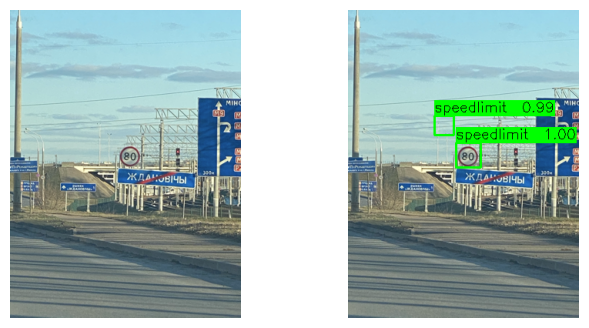

In [13]:
img_view = cv2.imread('images/road769.png')
pyramid_imgs = pyramid(img=img_view, scale=scale, min_size=min_size)
bboxes = draw_all_bbox(pyramid_imgs=pyramid_imgs)
bboxes = nms(bboxes=bboxes, iou_threshold=0.05)
visualize_bbox(img=img_view, bboxes=bboxes, label_encoder=label_encoder)

In [14]:
import streamlit as st
st.title("AI Image Analysis")

# Tải ảnh lên
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Đọc ảnh
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, 1)

    # Hiển thị ảnh
    st.image(image, channels="BGR")

    # Tiền xử lý ảnh theo yêu cầu của mô hình
    processed_image = cv2.resize(image, (224, 224))  # Ví dụ resize ảnh
    processed_image = np.expand_dims(processed_image, axis=0)  # Thêm batch dimension
    pyramid_imgs = pyramid(img=img_view, scale=scale, min_size=min_size)
    bboxes = draw_all_bbox(pyramid_imgs=pyramid_imgs)
    bboxes = nms(bboxes=bboxes, iou_threshold=0.05)
    visualize_bbox(img=img_view, bboxes=bboxes, label_encoder=label_encoder)
    # Dự đoán
    # prediction = model.predict(processed_image)

    # Hiển thị kết quả
    st.write("Prediction: ")

2024-08-02 17:11:18.231 
  command:

    streamlit run C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
